# **Predicting Stock Prices with RNN**

/tmp/ipykernel_48/22263327.py:25: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(TICKER, start=START, end=END, progress=False)


Price           Close
Ticker           MSFT
Date                 
2015-01-02  39.933056
2015-01-05  39.565849
2015-01-06  38.985123
2015-01-07  39.480427
2015-01-08  40.641880
Downloaded rows: 2515
Price           Close
Ticker           MSFT
Date                 
2015-01-02  39.933056
2015-01-05  39.565849
2015-01-06  38.985123
2015-01-07  39.480427
2015-01-08  40.641880
Downloaded rows: 2515


/tmp/ipykernel_48/22263327.py:30: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(TICKER, start=START, end=END, progress=False)


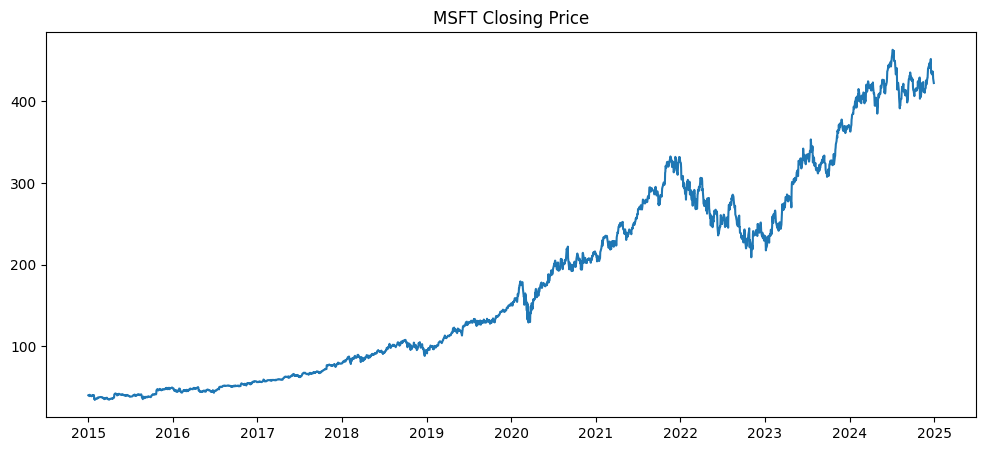

(1964, 60, 1) (491, 60, 1)
Epoch 1/10 — Train Loss: 0.036484, Test Loss: 0.024453
Epoch 2/10 — Train Loss: 0.001293, Test Loss: 0.001973
Epoch 3/10 — Train Loss: 0.000418, Test Loss: 0.003797
Epoch 4/10 — Train Loss: 0.000367, Test Loss: 0.004411
Epoch 5/10 — Train Loss: 0.000363, Test Loss: 0.004480
Epoch 6/10 — Train Loss: 0.000326, Test Loss: 0.002646
Epoch 7/10 — Train Loss: 0.000351, Test Loss: 0.003892
Epoch 8/10 — Train Loss: 0.000357, Test Loss: 0.005845
Epoch 9/10 — Train Loss: 0.000309, Test Loss: 0.006207
Epoch 10/10 — Train Loss: 0.000314, Test Loss: 0.002704


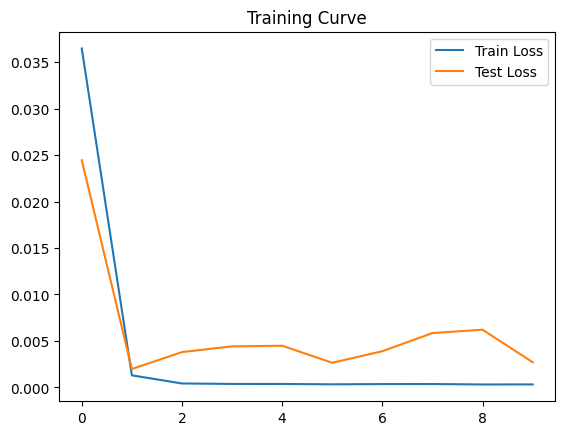

In [1]:
!pip install yfinance --quiet
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
TICKER = "MSFT"   # change this to any stock symbol
START = "2015-01-01"
END = "2024-12-31"

SEQ_LEN = 60
TEST_SIZE = 0.2
BATCH_SIZE = 32
EPOCHS = 10
LR = 0.001

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
df = yf.download(TICKER, start=START, end=END, progress=False)

df = df[["Close"]]
print(df.head())
print("Downloaded rows:", len(df))
df = yf.download(TICKER, start=START, end=END, progress=False)

df = df[["Close"]]
print(df.head())
print("Downloaded rows:", len(df))
plt.figure(figsize=(12,5))
plt.plot(df["Close"])
plt.title(f"{TICKER} Closing Price")
plt.show()

scaler = MinMaxScaler()
scaled = scaler.fit_transform(df.values)

def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(seq_len, len(data)):
        X.append(data[i-seq_len:i])
        y.append(data[i])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled, SEQ_LEN)

split = int((1 - TEST_SIZE) * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(X_train.shape, X_test.shape)

class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = StockDataset(X_train, y_train)
test_ds = StockDataset(X_test, y_test)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE)

class LSTMModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=1, 
            hidden_size=64, 
            num_layers=2,
            batch_first=True,
            dropout=0.2
        )
        self.fc = nn.Linear(64, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]   # last time-step
        out = self.fc(out)
        return out

model = LSTMModel().to(DEVICE)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

train_losses = []
test_losses = []

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    
    for xb, yb in train_dl:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)

        optimizer.zero_grad()
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    train_losses.append(total_loss / len(train_dl))

    # Evaluate
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in test_dl:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            pred = model(xb)
            loss = loss_fn(pred, yb)
            val_loss += loss.item()

    test_losses.append(val_loss / len(test_dl))

    print(f"Epoch {epoch+1}/{EPOCHS} — Train Loss: {train_losses[-1]:.6f}, Test Loss: {test_losses[-1]:.6f}")
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.legend()
plt.title("Training Curve")
plt.show()




# **Generating sinusodial wave with RNN**


===== STEP 1: Generate Sinusoidal Data =====
Time vector shape: (500,)
Sine wave shape: (500,)


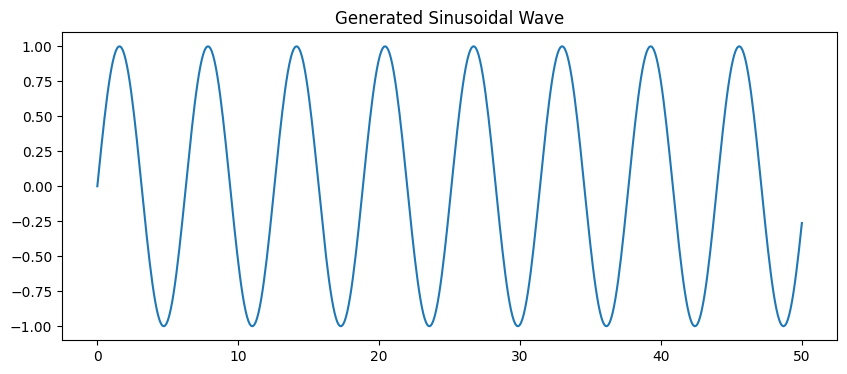


===== STEP 2: Prepare Sequences for RNN =====
X shape (samples, seq_len): (480, 20)
y shape (samples): (480,)
X tensor shape (batch, seq, feature): torch.Size([480, 20, 1])
y tensor shape: torch.Size([480, 1])

===== STEP 3: Define RNN Model =====
SimpleRNN(
  (rnn): RNN(1, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

===== STEP 4: Train the Model =====
Epoch 10/50, Loss = 0.050396
Epoch 20/50, Loss = 0.011737
Epoch 30/50, Loss = 0.001204
Epoch 40/50, Loss = 0.000846
Epoch 50/50, Loss = 0.000522

===== STEP 5: Predict Using the Trained Model =====
Prediction shape: (480, 1)

===== STEP 6: Plot True vs Predicted Sinusoidal Wave =====


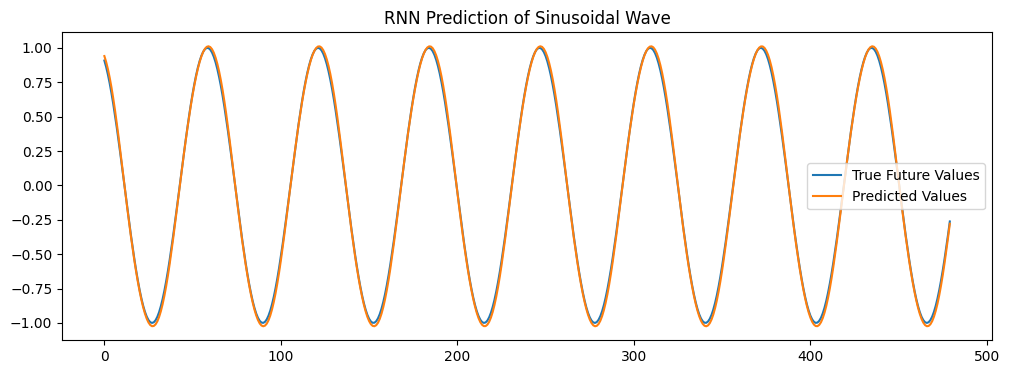


===== DONE ✓ =====


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

print("\n===== STEP 1: Generate Sinusoidal Data =====")
# Generate a sine wave
t = np.linspace(0, 50, 500)        # 500 time points
data = np.sin(t)

print("Time vector shape:", t.shape)
print("Sine wave shape:", data.shape)

# Plot the generated sine wave
plt.figure(figsize=(10,4))
plt.plot(t, data)
plt.title("Generated Sinusoidal Wave")
plt.show()

print("\n===== STEP 2: Prepare Sequences for RNN =====")
SEQ_LEN = 20    # number of timesteps for input

X, y = [], []
for i in range(len(data) - SEQ_LEN):
    X.append(data[i:i+SEQ_LEN])
    y.append(data[i+SEQ_LEN])

X = np.array(X)
y = np.array(y)

print("X shape (samples, seq_len):", X.shape)
print("y shape (samples):", y.shape)

# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)  # add feature dimension
y = torch.tensor(y, dtype=torch.float32).unsqueeze(-1)

print("X tensor shape (batch, seq, feature):", X.shape)
print("y tensor shape:", y.shape)

print("\n===== STEP 3: Define RNN Model =====")

class SimpleRNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = nn.RNN(input_size=1, hidden_size=32, num_layers=1, batch_first=True)
        self.fc = nn.Linear(32, 1)

    def forward(self, x):
        # RNN returns (output, hidden_state)
        out, _ = self.rnn(x)
        last_timestep = out[:, -1, :]      # extract last step output
        return self.fc(last_timestep)

model = SimpleRNN()
print(model)

print("\n===== STEP 4: Train the Model =====")
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

EPOCHS = 50
for epoch in range(EPOCHS):
    model.train()

    pred = model(X)
    loss = loss_fn(pred, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS}, Loss = {loss.item():.6f}")

print("\n===== STEP 5: Predict Using the Trained Model =====")

model.eval()
with torch.no_grad():
    y_pred = model(X).numpy()

print("Prediction shape:", y_pred.shape)

print("\n===== STEP 6: Plot True vs Predicted Sinusoidal Wave =====")
plt.figure(figsize=(12,4))
plt.plot(y.numpy(), label="True Future Values")
plt.plot(y_pred, label="Predicted Values")
plt.title("RNN Prediction of Sinusoidal Wave")
plt.legend()
plt.show()

print("\n===== DONE ✓ =====")


# **Image Classfication using CNN**


===== STEP 1: Load and Prepare MNIST Dataset =====


100%|██████████| 9.91M/9.91M [00:00<00:00, 53.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.70MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 21.3MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.67MB/s]


Training samples: 60000
Testing samples: 10000

===== STEP 2: Define CNN Model =====
SimpleCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)
Using device: cpu

===== STEP 3: Define Loss Function & Optimizer =====
Loss: CrossEntropyLoss
Optimizer: Adam

===== STEP 4: Train the CNN =====
Epoch [1/3], Loss: 0.1866
Epoch [2/3], Loss: 0.0539
Epoch [3/3], Loss: 0.0372

===== STEP 5: Evaluate on Test Data =====
Test Accuracy: 98.50%

===== STEP 6: Predict a Few Test Images =====


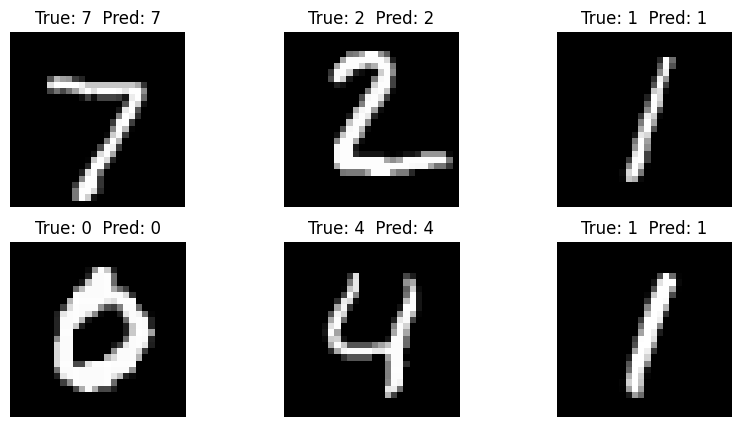


===== DONE ✓ Image Classification with CNN Completed =====


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

print("\n===== STEP 1: Load and Prepare MNIST Dataset =====")

# Transform: convert image to tensor + normalize
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))   # normalizing grayscale 0-1 to -1..1
])

# Download training & testing datasets
train_data = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_data  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

# Loaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_data, batch_size=64, shuffle=False)

print("Training samples:", len(train_data))
print("Testing samples:", len(test_data))


print("\n===== STEP 2: Define CNN Model =====")

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Convolution block 1
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)  # output shape: 16x28x28
        self.pool1 = nn.MaxPool2d(2, 2)                          # output shape: 16x14x14

        # Convolution block 2
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1) # output shape: 32x14x14
        self.pool2 = nn.MaxPool2d(2, 2)                          # output shape: 32x7x7

        # Fully connected layers
        self.fc1 = nn.Linear(32*7*7, 128)
        self.fc2 = nn.Linear(128, 10)  # 10 classes (0–9)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool1(x)
        x = torch.relu(self.conv2(x))
        x = self.pool2(x)

        x = x.view(x.size(0), -1)    # flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleCNN()
print(model)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
print("Using device:", device)


print("\n===== STEP 3: Define Loss Function & Optimizer =====")
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
print("Loss: CrossEntropyLoss")
print("Optimizer: Adam")


print("\n===== STEP 4: Train the CNN =====")
EPOCHS = 3  # keep small for quick demo

for epoch in range(EPOCHS):
    running_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {running_loss/len(train_loader):.4f}")


print("\n===== STEP 5: Evaluate on Test Data =====")

correct = 0
total = 0
model.eval()

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        _, predicted = torch.max(outputs, 1)  # predicted class index

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")


print("\n===== STEP 6: Predict a Few Test Images =====")

# Get a batch of test images
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

model.eval()
with torch.no_grad():
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

# Move to CPU for plotting
images = images.cpu()
preds = preds.cpu()
labels = labels.cpu()

# Visualize 6 predictions
plt.figure(figsize=(10,5))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(images[i].squeeze(), cmap="gray")
    plt.title(f"True: {labels[i].item()}  Pred: {preds[i].item()}")
    plt.axis("off")

plt.show()

print("\n===== DONE ✓ Image Classification with CNN Completed =====")


# **Object detection using CNN**


===================== STEP 1: Generate Synthetic Images =====================
Images shape: (1000, 64, 64)
Bounding boxes shape: (1000, 4)

===================== STEP 2: Create PyTorch Dataset =====================
Dataset ready. Total samples: 1000

===================== STEP 3: Define CNN for Bounding Box Prediction =====================
ObjectDetectorCNN(
  (cnn): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=4096, out_features=128, bias=True)
    (1

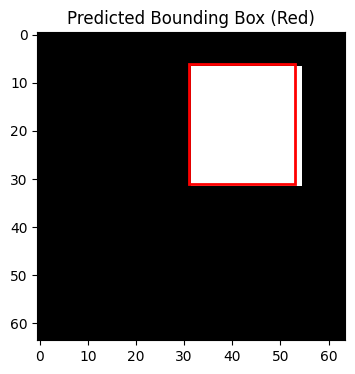


===================== DONE ✓ Object Detection Demo Complete =====================


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import random

print("\n===================== STEP 1: Generate Synthetic Images =====================")

# We generate black images with a white square.
# CNN must detect the square by predicting (x, y, width, height)

IMG_SIZE = 64
NUM_SAMPLES = 1000

def create_image():
    img = np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.float32)
    
    # Random square size and position
    w = random.randint(10, 25)
    h = random.randint(10, 25)
    x = random.randint(0, IMG_SIZE - w)
    y = random.randint(0, IMG_SIZE - h)

    img[y:y+h, x:x+w] = 1.0  # white square

    # bounding box format: x, y, w, h (normalized 0-1)
    bbox = np.array([x/IMG_SIZE, y/IMG_SIZE, w/IMG_SIZE, h/IMG_SIZE], dtype=np.float32)
    return img, bbox

# Create dataset
images, boxes = [], []
for _ in range(NUM_SAMPLES):
    img, bbox = create_image()
    images.append(img)
    boxes.append(bbox)

images = np.array(images)
boxes = np.array(boxes)

print("Images shape:", images.shape)
print("Bounding boxes shape:", boxes.shape)


print("\n===================== STEP 2: Create PyTorch Dataset =====================")

class SquareDataset(Dataset):
    def __init__(self, imgs, bboxes):
        self.imgs = torch.tensor(imgs).unsqueeze(1)  # add channel dim
        self.bboxes = torch.tensor(bboxes)

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        return self.imgs[idx], self.bboxes[idx]

dataset = SquareDataset(images, boxes)
loader = DataLoader(dataset, batch_size=32, shuffle=True)
print("Dataset ready. Total samples:", len(dataset))


print("\n===================== STEP 3: Define CNN for Bounding Box Prediction =====================")

class ObjectDetectorCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),   # 32×32
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),   # 16×16
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),   # 8×8
        )
        self.fc = nn.Sequential(
            nn.Linear(64*8*8, 128),
            nn.ReLU(),
            nn.Linear(128, 4)      # x, y, w, h
        )

    def forward(self, x):
        out = self.cnn(x)
        out = out.view(x.size(0), -1)
        out = self.fc(out)
        return out

model = ObjectDetectorCNN()
print(model)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
print("Using device:", device)


print("\n===================== STEP 4: Train CNN =====================")

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

EPOCHS = 10
for epoch in range(EPOCHS):
    running_loss = 0
    for imgs, bboxes in loader:
        imgs, bboxes = imgs.to(device), bboxes.to(device)

        optimizer.zero_grad()
        pred = model(imgs)
        loss = criterion(pred, bboxes)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {running_loss/len(loader):.6f}")


print("\n===================== STEP 5: Test a Sample Prediction =====================")

model.eval()
sample_img, sample_box = create_image()    # new unseen image
tensor_img = torch.tensor(sample_img).unsqueeze(0).unsqueeze(0).to(device)

with torch.no_grad():
    pred_box = model(tensor_img).cpu().numpy()[0]

# convert back to pixel coordinates
px, py, pw, ph = pred_box
px, py, pw, ph = int(px*IMG_SIZE), int(py*IMG_SIZE), int(pw*IMG_SIZE), int(ph*IMG_SIZE)

tx, ty, tw, th = sample_box

print("\nTrue box (normalized): ", sample_box)
print("Predicted box (normalized): ", pred_box)

print("\nPredicted pixel box:", (px, py, pw, ph))

# Plot Prediction
fig, ax = plt.subplots(1,1, figsize=(4,4))
ax.imshow(sample_img, cmap="gray")
rect = plt.Rectangle((px, py), pw, ph, edgecolor='red', facecolor='none', linewidth=2)
ax.add_patch(rect)
ax.set_title("Predicted Bounding Box (Red)")
plt.show()

print("\n===================== DONE ✓ Object Detection Demo Complete =====================")


# **Planar data classification** # 


===================== STEP 1: Generate Planar Data =====================
X shape: (2, 800)
y shape: (1, 800)


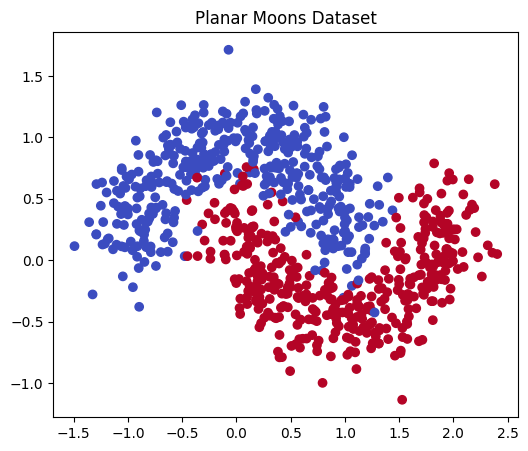


===================== STEP 2: Define Neural Network Structure =====================
Network: 2 → 4 → 1

===================== STEP 3: Initialize Weights =====================
W1: (4, 2) b1: (4, 1)
W2: (1, 4) b2: (1, 1)

===================== STEP 4: Define Helper Functions =====================

===================== STEP 5: Train the Network =====================
Iteration 0 - Cost: 0.6931
Iteration 1000 - Cost: 0.2902
Iteration 2000 - Cost: 0.2909
Iteration 3000 - Cost: 0.2891
Iteration 4000 - Cost: 0.0792
Iteration 5000 - Cost: 0.0767
Iteration 6000 - Cost: 0.0761
Iteration 7000 - Cost: 0.0758
Iteration 8000 - Cost: 0.0756

===================== STEP 6: Plot Decision Boundary =====================


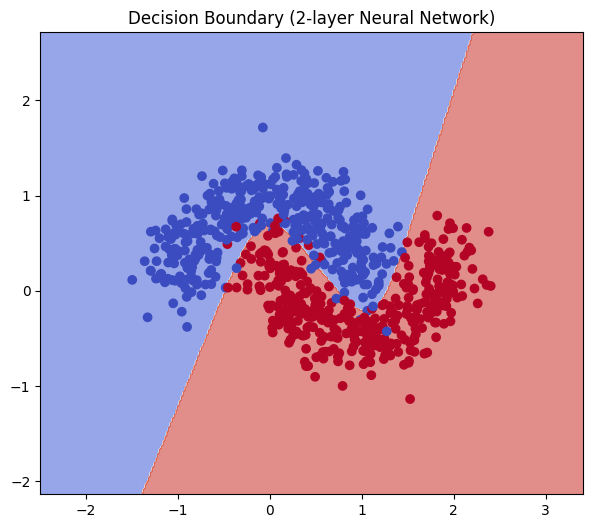


===================== DONE ✓ Planar Data Classification Complete =====================


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

print("\n===================== STEP 1: Generate Planar Data =====================")

# Make 2D 'moons' dataset
X, y = make_moons(n_samples=800, noise=0.2)
X = X.T                        # shape (2, N)
y = y.reshape(1, -1)           # shape (1, N)

print("X shape:", X.shape)
print("y shape:", y.shape)

# Plot dataset
plt.figure(figsize=(6,5))
plt.scatter(X[0, :], X[1, :], c=y.squeeze(), cmap="coolwarm")
plt.title("Planar Moons Dataset")
plt.show()


print("\n===================== STEP 2: Define Neural Network Structure =====================")

n_x = X.shape[0]     # input nodes = 2
n_h = 4              # hidden layer size (you can change)
n_y = 1              # output node

print(f"Network: {n_x} → {n_h} → {n_y}")


print("\n===================== STEP 3: Initialize Weights =====================")

np.random.seed(0)
W1 = np.random.randn(n_h, n_x) * 0.01
b1 = np.zeros((n_h, 1))
W2 = np.random.randn(n_y, n_h) * 0.01
b2 = np.zeros((n_y, 1))

print("W1:", W1.shape, "b1:", b1.shape)
print("W2:", W2.shape, "b2:", b2.shape)


print("\n===================== STEP 4: Define Helper Functions =====================")

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def forward_propagation(X):
    """Forward pass through 1 hidden layer"""
    Z1 = W1 @ X + b1
    A1 = np.tanh(Z1)
    Z2 = W2 @ A1 + b2
    A2 = sigmoid(Z2)
    return Z1, A1, Z2, A2

def compute_cost(A2, y):
    m = y.shape[1]
    return -np.mean(y*np.log(A2+1e-9) + (1-y)*np.log(1-A2+1e-9))

def backward_propagation(X, y, Z1, A1, Z2, A2):
    """Compute gradients manually"""
    m = X.shape[1]

    dZ2 = A2 - y
    dW2 = dZ2 @ A1.T / m
    db2 = np.sum(dZ2, axis=1, keepdims=True) / m

    dZ1 = (W2.T @ dZ2) * (1 - np.power(A1, 2))  # derivative of tanh
    dW1 = dZ1 @ X.T / m
    db1 = np.sum(dZ1, axis=1, keepdims=True) / m

    return dW1, db1, dW2, db2


print("\n===================== STEP 5: Train the Network =====================")

learning_rate = 1.0
iterations = 9000

for i in range(iterations):
    Z1, A1, Z2, A2 = forward_propagation(X)
    cost = compute_cost(A2, y)

    dW1, db1, dW2, db2 = backward_propagation(X, y, Z1, A1, Z2, A2)

    # Gradient descent update
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2

    if i % 1000 == 0:
        print(f"Iteration {i} - Cost: {cost:.4f}")


print("\n===================== STEP 6: Plot Decision Boundary =====================")

def predict(X):
    _, _, _, A2 = forward_propagation(X)
    return (A2 > 0.5).astype(int)

# Create a grid
x_min, x_max = X[0, :].min()-1, X[0, :].max()+1
y_min, y_max = X[1, :].min()-1, X[1, :].max()+1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))

grid = np.c_[xx.ravel(), yy.ravel()].T
Z = predict(grid)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(7,6))
plt.contourf(xx, yy, Z, cmap="coolwarm", alpha=0.6)
plt.scatter(X[0,:], X[1,:], c=y.squeeze(), cmap="coolwarm")
plt.title("Decision Boundary (2-layer Neural Network)")
plt.show()

print("\n===================== DONE ✓ Planar Data Classification Complete =====================")


# **Hyperparameter tuning and batch normalisation******

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import time

print("\n======================= STEP 1: Load Dataset =======================")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_set = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_set  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_set, batch_size=64, shuffle=False)

print("Train samples:", len(train_set))
print("Test samples:", len(test_set))


print("\n======================= STEP 2: Define CNN with Batch Normalization =======================")

class CNNWithBN(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.bn1   = nn.BatchNorm2d(16)       # Batch Norm applied to conv layer
        
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.bn2   = nn.BatchNorm2d(32)
        
        self.fc1   = nn.Linear(32*7*7, hidden_size)
        self.bn3   = nn.BatchNorm1d(hidden_size)   # BN for fully-connected layer
        
        self.fc2   = nn.Linear(hidden_size, 10)

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = torch.max_pool2d(x, 2)
        
        x = torch.relu(self.bn2(self.conv2(x)))
        x = torch.max_pool2d(x, 2)
        
        x = x.view(x.size(0), -1)
        x = torch.relu(self.bn3(self.fc1(x)))
        
        return self.fc2(x)

print("CNN architecture with Batch Normalization:")
print(CNNWithBN(128))


print("\n======================= STEP 3: Hyperparameter Tuning Setup =======================")

learning_rates = [0.001, 0.01]
hidden_sizes   = [64, 128]

print("Hyperparameter grid:")
print("Learning rates:", learning_rates)
print("Hidden sizes:", hidden_sizes)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)


def train_and_eval(lr, hidden_size):
    """Train model with given hyperparameters and return test accuracy."""
    model = CNNWithBN(hidden_size).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    
    # Train for 1 epoch (demo)
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
    
    # Evaluate
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, pred = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (pred == labels).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy


print("\n======================= STEP 4: Running Hyperparameter Grid Search =======================")

best_acc = 0
best_hp = None

for lr in learning_rates:
    for hs in hidden_sizes:
        print(f"\nTraining model with LR={lr}, Hidden Size={hs}")
        start = time.time()
        
        acc = train_and_eval(lr, hs)
        
        print(f"Validation Accuracy = {acc:.2f}%")
        print("Time taken: %.2fs" % (time.time() - start))
        
        if acc > best_acc:
            best_acc = acc
            best_hp = (lr, hs)

print("\n======================= STEP 5: Best Hyperparameters =======================")
print(f"Best Accuracy: {best_acc:.2f}%")
print(f"Best Learning Rate: {best_hp[0]}")
print(f"Best Hidden Size:  {best_hp[1]}")

print("\n======================= DONE ✓ Hyperparameter Tuning + Batch Normalization =======================")



======================= STEP 1: Load Dataset =======================
Train samples: 60000
Test samples: 10000

======================= STEP 2: Define CNN with Batch Normalization =======================
CNN architecture with Batch Normalization:
CNNWithBN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1568, out_features=128, bias=True)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

======================= STEP 3: Hyperparameter Tuning Setup =======================
Hyperparameter grid:
Learning rates: [0.001, 0.01]
Hidden sizes: [64, 128]
Using device: cpu

================

# **Logistic Regression with neural network**


=============== STEP 1: Generate Binary Classification Data ===============
X shape: (2, 1000)
y shape: (1, 1000)


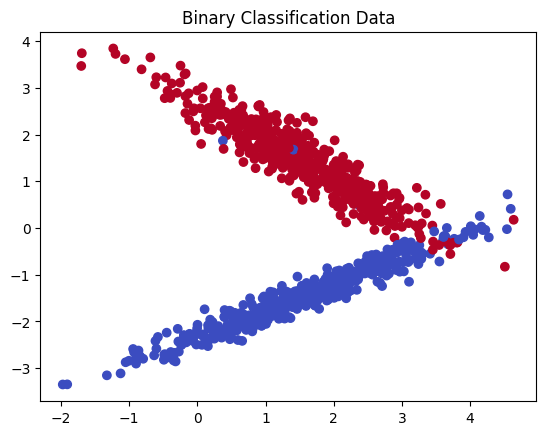


=============== STEP 2: Initialize Parameters ===============
W shape: (1, 2)
b: 0

=============== STEP 3: Define Helper Functions ===============

=============== STEP 4: Training the Logistic Regression Model ===============
Iteration 0  Cost = 0.6931
Iteration 500  Cost = 0.0958
Iteration 1000  Cost = 0.0900
Iteration 1500  Cost = 0.0884
Iteration 2000  Cost = 0.0878
Iteration 2500  Cost = 0.0875

=============== STEP 5: Make Predictions ===============
Training Accuracy: 97.20%

=============== STEP 6: Plot Decision Boundary ===============


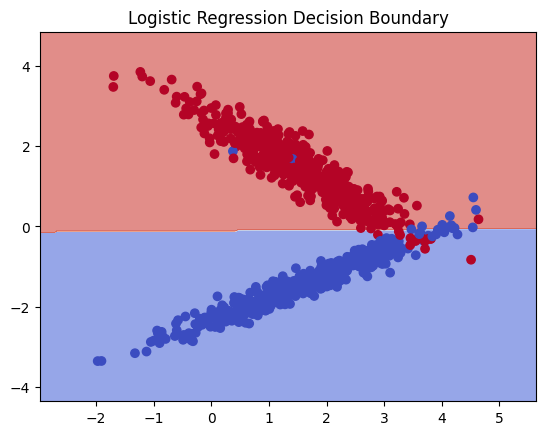


=============== DONE ✓ Logistic Regression with a Neural Network Completed ===============


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

print("\n=============== STEP 1: Generate Binary Classification Data ===============")

# Generate synthetic binary classification dataset
X, y = make_classification(
    n_samples=1000, n_features=2, n_redundant=0, n_clusters_per_class=1,
    n_classes=2, class_sep=1.5, random_state=42
)

# Transpose to (features, samples)
X = X.T
y = y.reshape(1, -1)

print("X shape:", X.shape)   # (2, N)
print("y shape:", y.shape)   # (1, N)

# Visualize data
plt.scatter(X[0, :], X[1, :], c=y.squeeze(), cmap="coolwarm")
plt.title("Binary Classification Data")
plt.show()


print("\n=============== STEP 2: Initialize Parameters ===============")

n_x = X.shape[0]             # number of input features
W = np.zeros((1, n_x))       # weights
b = 0                        # bias

print("W shape:", W.shape)
print("b:", b)


print("\n=============== STEP 3: Define Helper Functions ===============")

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def forward(W, b, X):
    """Compute predictions"""
    Z = np.dot(W, X) + b
    A = sigmoid(Z)
    return A

def compute_cost(A, y):
    """Binary cross-entropy loss"""
    m = y.shape[1]
    return -np.sum(y*np.log(A+1e-8) + (1-y)*np.log(1-A+1e-8)) / m

def backward(X, y, A):
    """Compute gradients"""
    m = y.shape[1]
    dZ = A - y
    dW = (1/m) * np.dot(dZ, X.T)
    db = (1/m) * np.sum(dZ)
    return dW, db


print("\n=============== STEP 4: Training the Logistic Regression Model ===============")

learning_rate = 0.1
iterations = 3000

for i in range(iterations):

    # Forward pass
    A = forward(W, b, X)

    # Compute cost
    cost = compute_cost(A, y)

    # Backward pass
    dW, db = backward(X, y, A)

    # Gradient descent update
    W -= learning_rate * dW
    b -= learning_rate * db

    if i % 500 == 0:
        print(f"Iteration {i}  Cost = {cost:.4f}")


print("\n=============== STEP 5: Make Predictions ===============")

A_final = forward(W, b, X)
predictions = (A_final > 0.5).astype(int)
accuracy = 100 * np.mean(predictions == y)
print(f"Training Accuracy: {accuracy:.2f}%")


print("\n=============== STEP 6: Plot Decision Boundary ===============")

# Create grid for plotting
x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))

grid = np.c_[xx.ravel(), yy.ravel()].T

# Predict on grid
A_grid = forward(W, b, grid)
Z = (A_grid > 0.5).astype(int).reshape(xx.shape)

# Plot boundary
plt.contourf(xx, yy, Z, cmap="coolwarm", alpha=0.6)
plt.scatter(X[0, :], X[1, :], c=y.squeeze(), cmap="coolwarm")
plt.title("Logistic Regression Decision Boundary")
plt.show()

print("\n=============== DONE ✓ Logistic Regression with a Neural Network Completed ===============")


# **Backpropagation**


========================= STEP 1: Load Dataset =========================
X shape: (150, 4)
y shape: (150, 1)
One-hot y shape: (150, 3)
X_train: (4, 120)
y_train: (3, 120)

========================= STEP 2: Network Architecture =========================
Network structure: 4 → 6 → 3

========================= STEP 3: Initialize Weights =========================
W1: (6, 4)  b1: (6, 1)
W2: (3, 6)  b2: (3, 1)

========================= STEP 4: Helper Functions =========================

========================= STEP 5: Train the Network =========================
Iteration 0 — Loss: 1.0986
Iteration 500 — Loss: 0.1010
Iteration 1000 — Loss: 0.0648
Iteration 1500 — Loss: 0.0560
Iteration 2000 — Loss: 0.0522
Iteration 2500 — Loss: 0.0502
Iteration 3000 — Loss: 0.0489
Iteration 3500 — Loss: 0.0480
Iteration 4000 — Loss: 0.0474
Iteration 4500 — Loss: 0.0469

========================= STEP 6: Plot Training Loss =========================


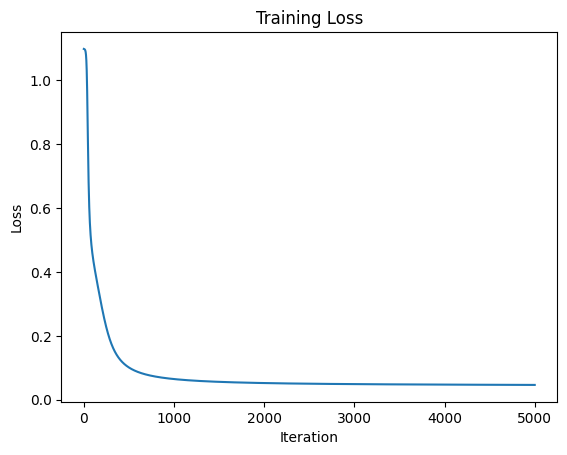


========================= STEP 7: Accuracy Evaluation =========================
Training Accuracy: 98.33%
Testing Accuracy:  100.00%

========================= DONE ✓ Backpropagation Implemented Successfully =========================


In [15]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

print("\n========================= STEP 1: Load Dataset =========================")

data = load_iris()
X = data.data                       # shape (150,4)
y = data.target.reshape(-1, 1)      # shape (150,1)

print("X shape:", X.shape)
print("y shape:", y.shape)

# Normalize features
X = (X - X.mean(axis=0)) / X.std(axis=0)

# One-hot encode 3 classes
enc = OneHotEncoder(sparse_output=False)
y_oh = enc.fit_transform(y)         # shape (150,3)
print("One-hot y shape:", y_oh.shape)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_oh, test_size=0.2, random_state=42
)

X_train = X_train.T
X_test  = X_test.T
y_train = y_train.T
y_test  = y_test.T

print("X_train:", X_train.shape)
print("y_train:", y_train.shape)


print("\n========================= STEP 2: Network Architecture =========================")

n_x = X_train.shape[0]   # 4 features
n_h = 6                  # hidden neurons
n_y = y_train.shape[0]   # 3 classes

print(f"Network structure: {n_x} → {n_h} → {n_y}")


print("\n========================= STEP 3: Initialize Weights =========================")

np.random.seed(1)
W1 = np.random.randn(n_h, n_x) * 0.01
b1 = np.zeros((n_h, 1))
W2 = np.random.randn(n_y, n_h) * 0.01
b2 = np.zeros((n_y, 1))

print("W1:", W1.shape, " b1:", b1.shape)
print("W2:", W2.shape, " b2:", b2.shape)


print("\n========================= STEP 4: Helper Functions =========================")

def softmax(z):
    exp = np.exp(z - np.max(z, axis=0, keepdims=True))
    return exp / np.sum(exp, axis=0, keepdims=True)

def forward_prop(X):
    Z1 = W1 @ X + b1
    A1 = np.tanh(Z1)
    Z2 = W2 @ A1 + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

def compute_cost(A2, Y):
    m = Y.shape[1]
    return -np.sum(Y * np.log(A2 + 1e-9)) / m

def backward_prop(X, Y, Z1, A1, Z2, A2):
    m = X.shape[1]
    
    dZ2 = A2 - Y
    dW2 = (1/m) * (dZ2 @ A1.T)
    db2 = (1/m) * np.sum(dZ2, axis=1, keepdims=True)
    
    dA1 = W2.T @ dZ2
    dZ1 = dA1 * (1 - np.power(A1, 2))   # tanh derivative
    dW1 = (1/m) * (dZ1 @ X.T)
    db1 = (1/m) * np.sum(dZ1, axis=1, keepdims=True)

    return dW1, db1, dW2, db2


print("\n========================= STEP 5: Train the Network =========================")

learning_rate = 0.1
iterations = 5000
losses = []

for i in range(iterations):
    Z1, A1, Z2, A2 = forward_prop(X_train)
    cost = compute_cost(A2, y_train)

    dW1, db1, dW2, db2 = backward_prop(X_train, y_train, Z1, A1, Z2, A2)

    # Gradient descent
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2

    if i % 500 == 0:
        print(f"Iteration {i} — Loss: {cost:.4f}")
    losses.append(cost)


print("\n========================= STEP 6: Plot Training Loss =========================")

plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()


print("\n========================= STEP 7: Accuracy Evaluation =========================")

def predict(X):
    _, _, _, A2 = forward_prop(X)
    return np.argmax(A2, axis=0)

train_pred = predict(X_train)
test_pred  = predict(X_test)

train_acc = np.mean(train_pred == np.argmax(y_train, axis=0)) * 100
test_acc  = np.mean(test_pred  == np.argmax(y_test, axis=0)) * 100

print(f"Training Accuracy: {train_acc:.2f}%")
print(f"Testing Accuracy:  {test_acc:.2f}%")


print("\n========================= DONE ✓ Backpropagation Implemented Successfully =========================")


# **Perceptron learning to classify alphabets**

In [16]:
import numpy as np

print("\n==================== STEP 1: Define 5×7 Pixel Alphabets ====================")

# Each alphabet is represented as a 5×7 binary matrix (like dot-matrix LEDs)
# We create A, B, C, D

A = np.array([
    [0,1,1,1,0],
    [1,0,0,0,1],
    [1,0,0,0,1],
    [1,1,1,1,1],
    [1,0,0,0,1],
    [1,0,0,0,1],
    [1,0,0,0,1],
])

B = np.array([
    [1,1,1,1,0],
    [1,0,0,0,1],
    [1,0,0,0,1],
    [1,1,1,1,0],
    [1,0,0,0,1],
    [1,0,0,0,1],
    [1,1,1,1,0],
])

C = np.array([
    [0,1,1,1,1],
    [1,0,0,0,0],
    [1,0,0,0,0],
    [1,0,0,0,0],
    [1,0,0,0,0],
    [1,0,0,0,0],
    [0,1,1,1,1],
])

D = np.array([
    [1,1,1,0,0],
    [1,0,0,1,0],
    [1,0,0,0,1],
    [1,0,0,0,1],
    [1,0,0,0,1],
    [1,0,0,1,0],
    [1,1,1,0,0],
])

alphabet_map = {'A':A, 'B':B, 'C':C, 'D':D}

print("Defined alphabets: ", list(alphabet_map.keys()))

print("\n==================== STEP 2: Prepare Training Data ====================")

# Flatten each 5x7 matrix into a 35-dimensional vector
X = []
y = []

label_map = {'A':0, 'B':1, 'C':2, 'D':3}

for letter, img in alphabet_map.items():
    X.append(img.flatten())
    y.append(label_map[letter])

X = np.array(X)    # shape (4, 35)
y = np.array(y)    # 0,1,2,3

print("Input shape:", X.shape)
print("Labels:", y)


print("\n==================== STEP 3: One-Vs-All Perceptrons ====================")

# We create 4 perceptrons, one for A, one for B, one for C, one for D.
num_classes = 4
input_dim = X.shape[1]

# Initialize weights & bias for each perceptron
W = np.zeros((num_classes, input_dim))
b = np.zeros((num_classes, 1))

learning_rate = 0.1
epochs = 20


def perceptron_predict(x, W, b):
    """Return class index with highest activation"""
    activations = np.dot(W, x.reshape(-1,1)) + b
    return np.argmax(activations)


print("\n==================== STEP 4: Training (Perceptron Learning Rule) ====================")

for epoch in range(epochs):
    errors = 0
    for i in range(len(X)):
        xi = X[i]
        target = y[i]

        prediction = perceptron_predict(xi, W, b)

        if prediction != target:
            errors += 1
            # Perceptron learning rule (One-vs-All)
            W[target] += learning_rate * xi
            b[target] += learning_rate
            W[prediction] -= learning_rate * xi
            b[prediction] -= learning_rate

    print(f"Epoch {epoch+1}/{epochs} - Misclassifications = {errors}")

print("\nTraining complete!")


print("\n==================== STEP 5: Testing on All Alphabets ====================")

for letter, img in alphabet_map.items():
    x = img.flatten()
    pred_class = perceptron_predict(x, W, b)
    predicted_letter = list(label_map.keys())[list(label_map.values()).index(pred_class)]
    print(f"Input letter = {letter}  --> Predicted = {predicted_letter}")

print("\n==================== DONE ✓ Perceptron Learning Rule Implemented ====================")



==================== STEP 1: Define 5×7 Pixel Alphabets ====================
Defined alphabets:  ['A', 'B', 'C', 'D']

==================== STEP 2: Prepare Training Data ====================
Input shape: (4, 35)
Labels: [0 1 2 3]

==================== STEP 3: One-Vs-All Perceptrons ====================

==================== STEP 4: Training (Perceptron Learning Rule) ====================
Epoch 1/20 - Misclassifications = 3
Epoch 2/20 - Misclassifications = 1
Epoch 3/20 - Misclassifications = 3
Epoch 4/20 - Misclassifications = 2
Epoch 5/20 - Misclassifications = 3
Epoch 6/20 - Misclassifications = 0
Epoch 7/20 - Misclassifications = 0
Epoch 8/20 - Misclassifications = 0
Epoch 9/20 - Misclassifications = 0
Epoch 10/20 - Misclassifications = 0
Epoch 11/20 - Misclassifications = 0
Epoch 12/20 - Misclassifications = 0
Epoch 13/20 - Misclassifications = 0
Epoch 14/20 - Misclassifications = 0
Epoch 15/20 - Misclassifications = 0
Epoch 16/20 - Misclassifications = 0
Epoch 17/20 - Misclassifi

# **GAN image generation**

In [8]:
# ===================== YOUR GAN CODE (KAGGLE-FRIENDLY) ======================

import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

# ==================== MAKE KAGGLE OUTPUT FOLDER ====================
OUTPUT_DIR = "/kaggle/working/gan_images"
os.makedirs(OUTPUT_DIR, exist_ok=True)
print("Generated images will be saved to:", OUTPUT_DIR)

# ==================== 1. GENERATOR ====================
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1),
                                     padding='same', use_bias=False))
    model.add(layers.BatchNormalization()); model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2),
                                     padding='same', use_bias=False))
    model.add(layers.BatchNormalization()); model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2),
                                     padding='same', use_bias=False,
                                     activation='tanh'))
    return model

# ==================== 2. DISCRIMINATOR ====================
def make_discriminator_model():
    model = tf.keras.Sequential()

    model.add(layers.Conv2D(64, (5, 5), strides=2, padding='same',
                            input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU()); model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=2, padding='same'))
    model.add(layers.LeakyReLU()); model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

# ==================== 3. LOSSES & OPTIMIZERS ====================
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    return (cross_entropy(tf.ones_like(real_output), real_output) +
            cross_entropy(tf.zeros_like(fake_output), fake_output))

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer     = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# ==================== 4. LOAD + PREPROCESS DATA ====================
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape(-1, 28, 28, 1).astype("float32")
train_images = (train_images - 127.5) / 127.5   # Normalize to [-1,1]

BUFFER_SIZE = 60000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_images)\
                               .shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# ==================== 5. TRAINING SETUP ====================
EPOCHS = 5
noise_dim = 100
NUM_EXAMPLES = 16

seed = tf.random.normal([NUM_EXAMPLES, noise_dim])

generator     = make_generator_model()
discriminator = make_discriminator_model()

@tf.function
def train_step(images):
    noise = tf.random.normal([tf.shape(images)[0], noise_dim])


    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss  = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_gen  = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_disc = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_gen, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_disc, discriminator.trainable_variables))

    return gen_loss, disc_loss

# ==================== 6. SAVE IMAGES (KAGGLE SAFE) ====================
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap="gray")
        plt.axis("off")

    path = f"{OUTPUT_DIR}/epoch_{epoch:04d}.png"
    plt.savefig(path)
    plt.close()
    print(f"[✓] Saved image: {path}")

# ==================== 7. TRAIN LOOP ====================
def train(dataset, epochs):
    for epoch in range(epochs):
        g_losses, d_losses = [], []

        for batch in dataset:
            g_loss, d_loss = train_step(batch)
            g_losses.append(g_loss)
            d_losses.append(d_loss)

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Gen Loss: {tf.reduce_mean(g_losses):.4f} | "
              f"Disc Loss: {tf.reduce_mean(d_losses):.4f}")

        if (epoch + 1) % 5 == 0 or epoch == 0:
            generate_and_save_images(generator, epoch + 1, seed)

    generate_and_save_images(generator, epochs, seed)
    print("\nTraining completed successfully!")

# ==================== 8. RUN TRAINING ====================
train(train_dataset, EPOCHS)
print("\nAll generated images are stored in:", OUTPUT_DIR)


TensorFlow version: 2.18.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Generated images will be saved to: /kaggle/working/gan_images
Epoch 1/5 | Gen Loss: 0.6863 | Disc Loss: 1.1743
[✓] Saved image: /kaggle/working/gan_images/epoch_0001.png
Epoch 2/5 | Gen Loss: 0.7820 | Disc Loss: 1.2522
Epoch 3/5 | Gen Loss: 0.8785 | Disc Loss: 1.2578
Epoch 4/5 | Gen Loss: 0.7830 | Disc Loss: 1.3311
Epoch 5/5 | Gen Loss: 0.8871 | Disc Loss: 1.2738
[✓] Saved image: /kaggle/working/gan_images/epoch_0005.png
[✓] Saved image: /kaggle/working/gan_images/epoch_0005.png

Training completed successfully!

All generated images are stored in: /kaggle/working/gan_images
